<center>

*******************************************************************************************
    
### Correlation Analysis of Nasdaq Nordic Stocks priced in Euros
  
#####  2 July 2024

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

##### INFORMATION:

* Description:

    Analysis of historical data from stocks traded in Euros at Nasdaq Nordic.
    * Pairwise Pearson's correlation of average prices.
    * Grouping by Industry and Supersector
    * Visualisation of notable examples.
>
* Rationale:

    When investing in more than one stock, it may be convenient to ensure that they are not highly inter-correlated, positively or negatively. Correlated stocks  will have similar risks. For example, highly correlated stocks will appreciate but also depreciate at the same time. The former could be an advantge but the latter is mostly risky. Oftentimes it is better to have a diversified set of stocks so that risks are counteracted.\
    $\;\;\;\;\;\;$ It is also important to consider that correlation may be very different at different time-scales. For example, stocks that during one or more yeara are negatively correlated, often are positively correlated at shorter time-scales like one month. At short times scales of weeks or days, stocks tend to follow short-term trends in the market.\
    $\;\;\;\;\;\;$ Only stocks priced in Euros are used in this analysis, to remove the effect of currency differences.
>
* Instructions:

    Edit the values indicated with an arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************


In [1410]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

***
### Set paths:

In [1411]:
data_folder = r"C:\Users\Daneel_Olivaw\Documents\nn_data" # <--- directory for files (e.g. stocks list, database)
stocks_folder = data_folder + r"\stocks" # <--- directory for CSV files with historical data
db_fn = data_folder + r'\nn_data.db' # <--- database file name (full path)

# The files in the stocks directory can be downloaded from the pages linked in 
# https://www.nasdaqomxnordic.com/shares

***
### Create database and load data, or just connect if database exists:

In [1412]:
def numtab(cursor,exclude):
    """
    Number of tables in database.
    INPUT:
        cursor: SQLite3 cursor.
        exclude: [list of strings] Names of tables to exclude in the count.
    """
    query = "SELECT name FROM sqlite_master  WHERE type='table' "
    query = query + ' '.join([f'AND name IS NOT' + f"'{str}'" for str in exclude])
    n_tables = len( cursor.execute(query).fetchall() )
    print(f"{n_tables} stock tables in the database")
    return n_tables

In [1413]:
vis_opt_cr_tab = 0 # <--- 1 = print if table already exist or has been created, 0 = don't

connection = sqlite3.connect(db_fn)
cursor = connection.cursor()

sel_cols = ['Date','Average price'] # columns of CSV file to put in table for each stock
tickers = [] # ticker list
n_new = 0
for src_fn in os.listdir(stocks_folder):

    table_name = src_fn.split('-')[0]
    table_name = table_name.replace('_',' ')

    if tickers.count( table_name ):
        print(f'WARNING: There is more than one file for {table_name}. Only the first was loaded.')
    else:
        tickers.append( table_name )

    csv_full_fn = stocks_folder + '\\' + src_fn
    
    separator = pd.read_csv( csv_full_fn, nrows = 0 ).columns[0].split('=')[1]
    csv_data_src = pd.read_csv( csv_full_fn, skiprows = 1, sep = separator, usecols = sel_cols,
                                decimal = ",", thousands = "." )
    try:
        rc = cursor.execute(f'SELECT COUNT(*) FROM "{table_name}"')
        if vis_opt_cr_tab:
            print(f'Table \'{table_name}\' already exists, and has {rc.fetchone()[0]} rows.')
    except:
        csv_data_src.to_sql( name = table_name, con = connection )
        n_new += 1
        if vis_opt_cr_tab:
            print(f'Table \'{table_name}\' created.')
n_tables = numtab(cursor,['nn_list','av_prices'])
if n_new > 0:
    print('of which all already existed')
else:
    print(f'of which {n_new} are new')

141 stock tables in the database
of which 0 are new


In [10]:
def printab(cursor,n):
    """
    Print column names and rows of a table.
    INPUT:
        cursor: SQLite3 cursor object with selected rows.
        n: Number of rows to print.
    """
    col_names = [row[0] for row in cursor.description]
    col_names_str = ', '.join(col_s)
    print(col_names_str)
    print('-'*len(col_s_str))
    c = 0
    for row in cursor.fetchall():
        c += 1
        print(', '.join([str(c) for c in row]))
        if n == c:
            break

In [11]:
# Inspect one table:

i_stock = 0 # <--- index of the stock in the ticker list

print(f'{tickers[i_stock]}\n')
printab( cursor.execute( f'SELECT * FROM {tickers[i_stock]}' ) , 5)

ACG1V

index, Date, Average price
--------------------------
0, 2024-06-26, 3.11
1, 2024-06-25, 3.053
2, 2024-06-24, 3.177
3, 2024-06-20, 3.091
4, 2024-06-19, 3.109


***
### Collect stocks' historical average prices in one table:

In [ ]:
# Create new table in database, with dates and one stock's daily average prices:

table_ticker = tickers[0]
query = f"""
            CREATE TABLE "av_prices" AS
            SELECT 
                Date,
                "Average price" AS "{table_ticker}"
            FROM {table_ticker}
            WHERE  
                Date > DATE('now','-1 year')
                AND 
                Date < DATE('now')
        """
cursor.execute(query);

# Put all remaining stocks daily average prices since one year into table:

for i_stock in range(1,n_tables):
    
    table_ticker = tickers[i_stock]
    cursor.execute(f'ALTER TABLE av_prices ADD COLUMN "{table_ticker}"');
    query = f"""
                UPDATE av_prices
                SET '{table_ticker}' = (
                                        SELECT "Average price"
                                        FROM '{table_ticker}'
                                        WHERE  
                                            Date > DATE('now','-1 year')
                                            AND 
                                            Date < DATE('now')
                                        AND Date = av_prices.Date
                                      );
            """
    cursor.execute(query);
    #print(f'{i_stock+1} of {n_tables}')
    
print('done')

In [ ]:
# Inspect table:

printab( cursor.execute('SELECT * FROM av_prices') ,5)

In [19]:
#If all good:
connection.commit()

#If not, delete the table and try again:
#cursor.execute('DROP TABLE av_prices');

***
### Sort stocks according to pairwise correlation:

In [1414]:
# Get all stocks from database into a dataframe:

data_df = pd.read_sql_query('SELECT * FROM av_prices', connection)
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df.set_index('Date', inplace = True)
data_df.head()

,ACG1V,AFAGR,AKTIA,ALBAV,ALBBV,ALISA,ALMA,ANORA,APETIT,ASPO,...,VAIAS,VALMT,VALOE,VERK,VIK1V,WETTERI,WITH,WRT1V,WUF1V,YIT
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-26,3.110,0.285,9.260,33.818,33.357,0.185,10.337,4.556,13.734,5.915,...,40.926,26.796,NaN,2.203,22.420,0.434,1.045,17.839,2.586,2.278
2024-06-25,3.053,0.282,9.349,34.352,33.447,0.184,10.210,4.520,13.842,5.867,...,41.388,26.929,NaN,2.204,22.070,0.430,1.054,18.385,2.406,2.326
2024-06-24,3.177,0.282,9.324,34.200,33.347,0.183,10.101,4.505,13.760,5.877,...,41.356,27.463,NaN,2.200,22.372,0.436,1.075,18.371,2.414,2.366
2024-06-20,3.091,0.278,9.360,34.329,33.558,0.183,9.944,4.500,14.048,5.851,...,40.798,26.935,NaN,2.192,22.272,0.438,1.075,18.486,2.450,2.409
2024-06-19,3.109,0.272,9.317,34.093,33.383,0.185,9.873,4.499,14.029,5.888,...,39.944,26.706,NaN,2.188,22.201,0.435,1.086,19.070,2.457,2.427


In [1415]:
def corrsort(data_df):
    """
    Compute pairwise correlation and sort according to descending correlation value.
    """
    corr_df = data_df.corr( method = 'pearson' )
    corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),1).astype(np.bool_))
    corr_df = corr_df.stack().reset_index()
    corr_df = corr_df.sort_values(0,ascending = False, inplace = False).reset_index(drop=True)
    corr_df.rename( columns = { 0 : 'r'}, inplace = True )
    return corr_df
    
corr_df = corrsort(data_df)
print(corr_df.shape)
corr_df.head()

(9870, 3)


,level_0,level_1,r
0,SSABAH,SSABBH,0.995440
1,ORNAV,ORNBV,0.988596
2,KESKOA,KESKOB,0.982371
3,CGCBV,KCR,0.975180
4,ALBAV,ALBBV,0.968694


In [1416]:
# Rearrange sequentially: 

corr_id_df = pd.concat([corr_df.iloc[:,0],corr_df.iloc[:,1]]).sort_index().reset_index(drop=True)
corr_r_df = pd.concat([corr_df.iloc[:,2:],corr_df.iloc[:,2:]]).sort_index().reset_index(drop=True)
corr_id_r_df = pd.concat( [corr_id_df,corr_r_df] , axis = 1 )
corr_id_r_df.rename( columns = { 0 : 'ticker'}, inplace = True )

print(corr_id_r_df.shape)
corr_id_r_df.iloc[:10]

(19740, 2)


,ticker,r
0,SSABAH,0.995440
1,SSABBH,0.995440
2,ORNBV,0.988596
3,ORNAV,0.988596
4,KESKOA,0.982371
5,KESKOB,0.982371
6,CGCBV,0.975180
7,KCR,0.975180
8,ALBAV,0.968694
9,ALBBV,0.968694


***
### Visualisation of correlation scores (Pearson´s r):

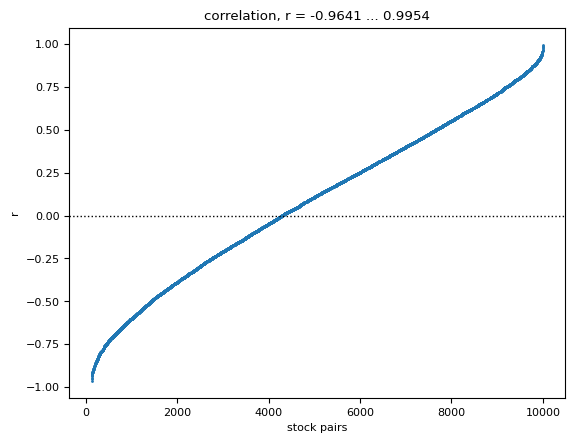

In [1580]:
fig, ax = plt.subplots()
plt.plot( corr_id_r_df['r'].unique() , 'o' , markersize = 1)
xt =[int(v) for v in ax.get_xticks()]
xt = xt[1:-1]
ax.set_xticks(xt)
ax.set_xticklabels(xt[::-1])
ax.invert_xaxis()
g_min_r = round(corr_id_r_df.iloc[-1,1],4)
g_max_r = round(corr_id_r_df.iloc[0,1],4)
ax.set_title(f"correlation, r = {g_min_r} ... {g_max_r}")
ax.set_xlabel('stock pairs')
ax.set_ylabel('r')
plt.axhline(y=0, color='k', linestyle=':', linewidth=1);

The correlation scores display an inverse sigmoid curve akin to the quantile function of a normal or logistic distribution.
<br></br>

***
### Visualisation of all data:

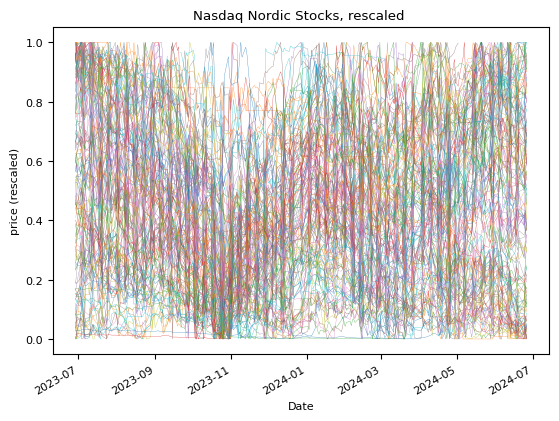

In [1579]:
rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

norm_lbl = ''
curr_lbl = ' (EUR)'
if rescale_opt:
    sel_df = data_df.copy()
    sel_df = sel_df - sel_df.min()
    sel_df = sel_df / sel_df.max()
    norm_lbl = ', rescaled '
    curr_lbl = ' (rescaled)'
else:
    sel_df = data_df

fig, ax = plt.subplots()
sel_df.plot( ax = ax, legend = None , linewidth = 0.2)
plt.title(f'Nasdaq Nordic Stocks{norm_lbl}')
plt.ylabel(f'price{curr_lbl}');

This rescaled plot of all Nasdaq Nordic stocks priced in Euros over a year shows a point of convergence at about the end of October 2023, where most stockes reached a minimum after declining for months, followed by an appreciation. This was a trend of stocks markets globally, possibly related to a spike in USA Treasury bonds attracting more capital, developments of the conflict in Gaza, and China's announcement of reduction in exports of Graphite to USA.

***
### Visualisation of pairwise correlation of stocks prices:

In [1554]:
def vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt):
    """
    Visualise stocks' prices and their pairwise-correlation.
    Compute correlation for time-ranges of less than full data.
    INPUT:
        data_df: [dataframe] row index: Date; colum index: stocks' identifier; data: stock prices
        corr_id_r_df: [dataframe] row index: stocks' identifier; data: correlation score
        start_date: [datetime] inclusive starting date to display (YYYY-MM-DD), '' = from first record 
        end_date: [datetime] inclusive ending date to display (YYYY-MM-DD), '' = until last record
        r_min_query: [float] inclusive minimum correlation to display
        r_max_query: [float] inclusive maximum correlation to display 
        rescale_opt: [boolean] True = rescale to [0,1], False = don't
    """
    
    mask_sel = (corr_id_r_df['r'] >= r_min_query) & (corr_id_r_df['r'] <= r_max_query)
    sel_stocks = corr_id_r_df['ticker'].loc[ mask_sel ]
    r_min_global = round( corr_id_r_df['r'].loc[ mask_sel[::-1].idxmax() ] ,4)
    r_max_global = round( corr_id_r_df['r'].loc[ mask_sel.idxmax() ] ,4)
    
    r_global_lbl = f'r = {r_min_global}'
    if r_min_global != r_max_global:
        r_global_lbl = r_global_lbl + f' ... {r_max_global}'
          
    if start_date or end_date:
        r_global_lbl = ' (' + r_global_lbl + f' for {data_df.index[-1].strftime("%Y-%m-%d")} to {data_df.index[0].strftime("%Y-%m-%d")})'
        local_view = True
    else:
        r_global_lbl = ', ' + r_global_lbl
        local_view = False
        
    if not start_date:
        start_date = data_df.index[-1].strftime('%Y-%m-%d')
    if not end_date:
        end_date = data_df.index[0].strftime('%Y-%m-%d')

    sel_df = data_df.query('index >= @start_date and index <= @end_date')[sel_stocks]
    r_local_lbl = ''
    if local_view:
        corr_df = corrsort(sel_df)
        r_min_local = round( corr_df['r'].iloc[-1] ,4)
        r_max_local = round( corr_df['r'].iloc[0] ,4)
        r_local_lbl = f', r = {r_min_local}'
        if r_min_local != r_max_local:
            r_local_lbl = r_local_lbl + f' ... {r_max_local}'
        r_local_lbl = r_local_lbl + '\n'
    norm_lbl = ''
    curr_lbl = ' (EUR)'
    if rescale_opt:
        sel_df = sel_df.copy()
        sel_df = sel_df - sel_df.min()
        sel_df = sel_df / sel_df.max()
        norm_lbl = ', rescaled '
        curr_lbl = ' (rescaled)'
    plt.rcParams.update({'font.size':8})
    fig, ax = plt.subplots()
    sel_df.plot(ax=ax)
    ax.legend(bbox_to_anchor=(1, 1.03), loc='upper left')
    plt.title(f'{start_date} - {end_date}{norm_lbl}{r_local_lbl}{r_global_lbl}')
    plt.ylabel(f'price{curr_lbl}')
    

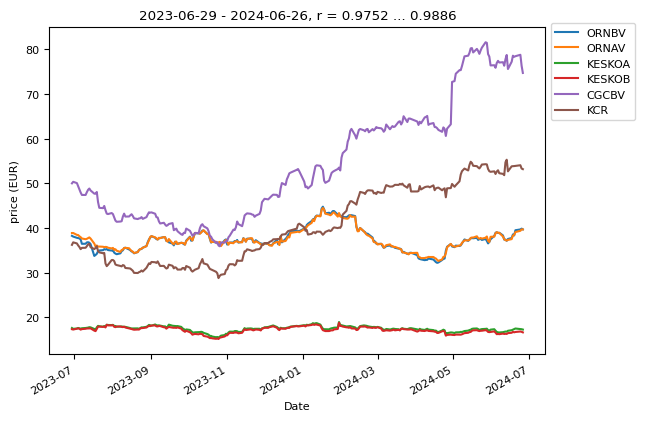

In [1555]:
# Visualise stock pairs:

r_min_query = 0.97 # <--- correlation minimum
r_max_query = 0.99 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 0 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### Very high positive correlation:
For some pairs the prices are almost identical, and one of the lines is almost completely obscured by the other. In those cases in the figure, the stocks correspond to the same issuer. Another form of high correlation can be observed (CGCBV vs. KCR), where the prices have similar trends over several months despite having a substantial gap.
<br></br>
<br></br>

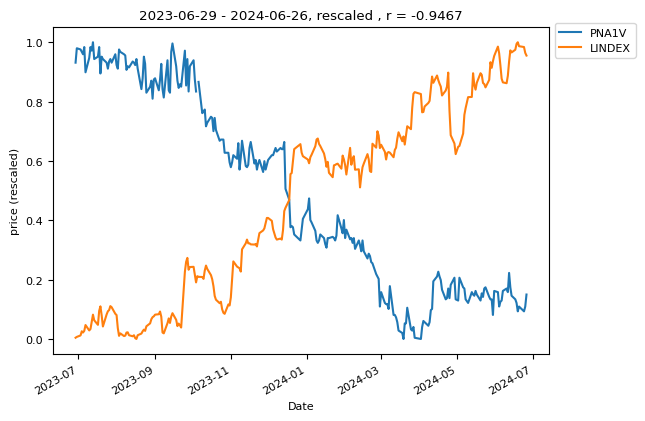

In [1556]:
# Visualise stock pairs:

r_min_query = -0.95 # <--- correlation minimum
r_max_query = -0.94 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### Very high negative correlation:
These two stocks display opposite trends during the displayed year. However, it is important to note that at other time scales there might be positive correlation, with or without the trend removed.\
Note that prices data have been rescaled between 0 and 1 for better visualisation.
<br></br>
<br></br>

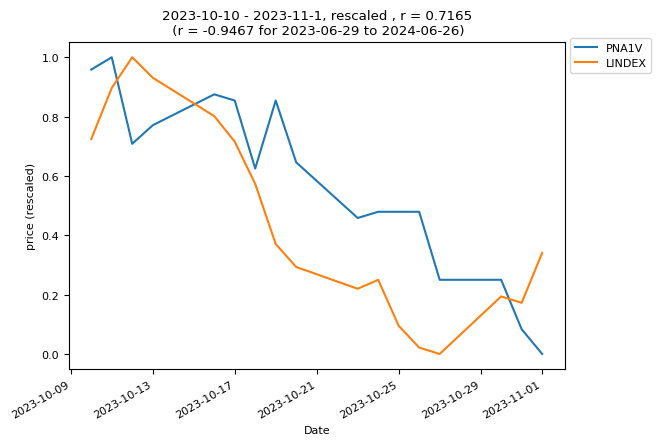

In [1557]:
# Visualise stock pairs:

r_min_query = -0.95 # <--- correlation minimum
r_max_query = -0.94 # <--- correlation maximum

start_date = '2023-10-10' # <--- inclusive start date, '' = from first data point in database
end_date = '2023-11-1'   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### Very high negative correlation on a one-year time-scale but positive correlation at a shorter time-scale.
Note that:
- Prices data have been rescaled between 0 and 1 for better visualisation.
- The correlation scores (r) for samples of different sizes (i.e., time ranges) are not directly comparable and are displayed here as reference. A more rigurous analysis would involve Fisher's z transform, with a more complex interpretation. For the assessment intended hire, the r values and visual display are enough.
<br></br>
<br></br>

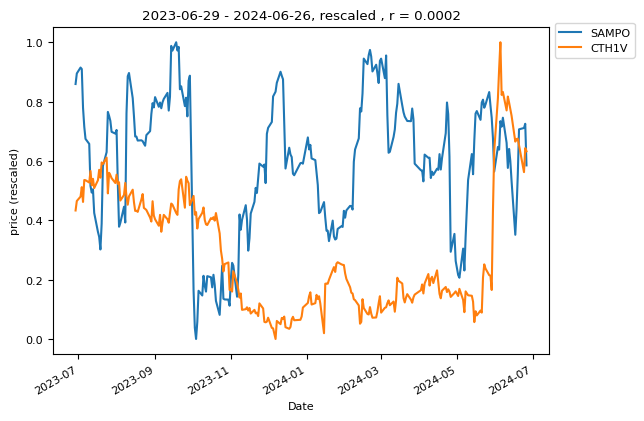

In [1558]:
# Visualise stock pairs:

r_min_query = 0 # <--- correlation minimum
r_max_query = 0.0002 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### No correlation:
No or negligible correlation may be observed on a one-year time-scale. However, there are periods of mostly positive but also negative correlation within.\
<br></br>

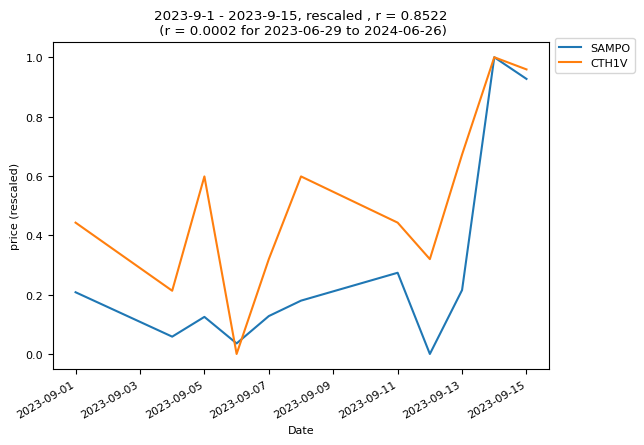

In [1559]:
# Visualise stock pairs:

r_min_query = 0 # <--- correlation minimum
r_max_query = 0.0002 # <--- correlation maximum

start_date = '2023-9-1' # <--- inclusive start date, '' = from first data point in database
end_date = '2023-9-15'   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### No correlation on a one-year time-scale but positive correlation at a shorter time-scale. 
<br></br>

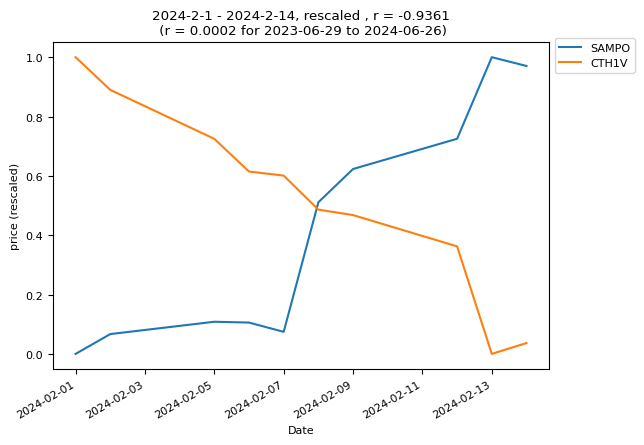

In [1560]:
# Visualise stock pairs:

r_min_query = 0 # <--- correlation minimum
r_max_query = 0.0002 # <--- correlation maximum

start_date = '2024-2-1' # <--- inclusive start date, '' = from first data point in database
end_date = '2024-2-14'   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### No correlation on a one-year time-scale but negative correlation at a shorter time-scale. 
<br></br>

***
### Group stocks according to industry and supersector:

In [1418]:
# Count stocks grouped Industry and Supersector:

query = """ 
            SELECT "Industry Code", Industry, "Supersector Code", Supersector, COUNT() as count
            FROM 'nn_list'
            WHERE Currency = 'EUR'
            GROUP BY Industry, Supersector
        """
sec_groups_df = pd.read_sql_query(query, connection)
print(sec_groups_df.shape)
sec_groups_df

(20, 5)


,Industry Code,Industry,Supersector Code,Supersector,count
0,55,Basic Materials,5510,Basic Resources,13
1,55,Basic Materials,5520,Chemicals,1
2,40,Consumer Discretionary,4010,Automobiles and Parts,2
3,40,Consumer Discretionary,4020,Consumer Products and Services,9
4,40,Consumer Discretionary,4030,Media,5
5,40,Consumer Discretionary,4040,Retail,7
6,40,Consumer Discretionary,4050,Travel and Leisure,4
7,45,Consumer Staples,4510,"Food, Beverage and Tobacco",6
8,45,Consumer Staples,4520,"Personal Care, Drug and Grocery Stores",3
9,60,Energy,6010,Energy,1


In [1419]:
# If one Supersector of an Industry has only one element, merge all supersectors of that Industry:

sec_groups_df = pd.read_sql_query(query, connection)

idx_once = np.where(sec_groups_df['count'] == 1)
idx_drop = []
for i in list(idx_once[0]) :
    idx_rep = list(np.where( sec_groups_df['Industry Code'] ==  sec_groups_df['Industry Code'][i] )[0])
    sec_groups_df.loc[ idx_rep , 'Supersector Code'] = 0
    sec_groups_df.loc[ idx_rep , 'Supersector'] = ''
    if len(idx_rep) > 1:
        idx_drop.extend(idx_rep[1:])

sec_groups_df.drop(index = idx_drop, inplace = True)
sec_groups_df.drop("count",axis=1, inplace = True) # to avoid confusion

# Eliminate repeated labels to make the subsequent SQL query a bit faster:
mask = sec_groups_df['Industry'] == sec_groups_df['Supersector'] # mask because the index has changed
sec_groups_df.loc[mask,'Supersector Code'] = 0
sec_groups_df.loc[mask,'Supersector'] = ''

print(sec_groups_df.shape)
sec_groups_df

(17, 4)


,Industry Code,Industry,Supersector Code,Supersector
0,55,Basic Materials,0,
2,40,Consumer Discretionary,4010,Automobiles and Parts
3,40,Consumer Discretionary,4020,Consumer Products and Services
4,40,Consumer Discretionary,4030,Media
5,40,Consumer Discretionary,4040,Retail
6,40,Consumer Discretionary,4050,Travel and Leisure
7,45,Consumer Staples,4510,"Food, Beverage and Tobacco"
8,45,Consumer Staples,4520,"Personal Care, Drug and Grocery Stores"
9,60,Energy,0,
10,30,Financials,0,


In [1420]:
# Get the Industry-Supersector groups from the database and store them in a dictionary ( { key : value } )
# { 'group label' : ['ticker'] } where value is a dataframe:

d_gr_ticker = {}
for i in range(sec_groups_df.shape[0]):
    
    if sec_groups_df.iloc[i,col_offset+2]:
        query_lbl = f'"Industry Code" = {sec_groups_df.iloc[i,0]} AND "Supersector Code" = {sec_groups_df.iloc[i,2]}'
        dict_lbl = ' - '.join([f'{str}' for str in sec_groups_df.iloc[i,1::2]])
    else:
        query_lbl = f'"Industry Code" = {sec_groups_df.iloc[i,0]}'
        dict_lbl = f'{sec_groups_df.iloc[i,1]}'
        
    #print(query_lbl)
    #print(dict_lbl)
    query = f""" 
            SELECT "Short Name" as ticker
            FROM nn_list
            WHERE 
                {query_lbl}    
                AND CURRENCY = 'EUR' 
        """
    this_group = pd.read_sql_query(query, connection)
    
    # check if all tickers exist in data and remove non-existent:
    idx_remove = []
    for i in range(len(this_group)):
        if this_group.iloc[i,0] not in data_df.columns:
            idx_remove.append(i)
            print(f'{this_group.iloc[i,0]} in list but not in data')

    if idx_remove:
        this_group.drop( idx_remove , inplace = True )
        this_group.reset_index( drop = True , inplace = True )

    if len(this_group) == 1:
        print(f'{this_group.iloc[i,0]} has only one element, no pairwise correlation possible.')
    else:
        d_gr_ticker[dict_lbl] = this_group
    

NESTE has only one element, no pairwise correlation possible.
EXL1VN0124 in list but not in data


In [1421]:
# Make dictionary for all { 'ticker-ticker' : r } where value is a list:
d_idid_r = {}
for i in range(corr_df.shape[0]):
    d_idid_r[ f"{corr_df.iloc[i,0]}-{corr_df.iloc[i,1]}" ] = corr_df.iloc[i,2]

# Make dictionary { 'group label' : ['ticker','ticker','r'] } where value is a nested list:
group_labels = list(d_gr_ticker.keys())
d_gr_corr = {}
for gr_lbl in group_labels:

    d_gr_corr[gr_lbl] = []
    sel_gr = d_gr_ticker[gr_lbl]
    for i, t1 in sel_gr.iterrows():
        for ii in range(i+1,sel_gr.shape[0]):

            k = f"{t1['ticker']}-{sel_gr.loc[ii]['ticker']}"
            row = [ t1['ticker'] , sel_gr.loc[ii]['ticker'] ]
            if k not in d_idid_r:
                k = f"{sel_gr.loc[ii]['ticker']}-{t1['ticker']}"
                row = [ sel_gr.loc[ii]['ticker'] , t1['ticker'] ]
            
            d_gr_corr[gr_lbl].append(  row + [ d_idid_r[k] ]  )
            d_gr_corr[gr_lbl].sort(key=lambda x: x[-1] , reverse=True )
            

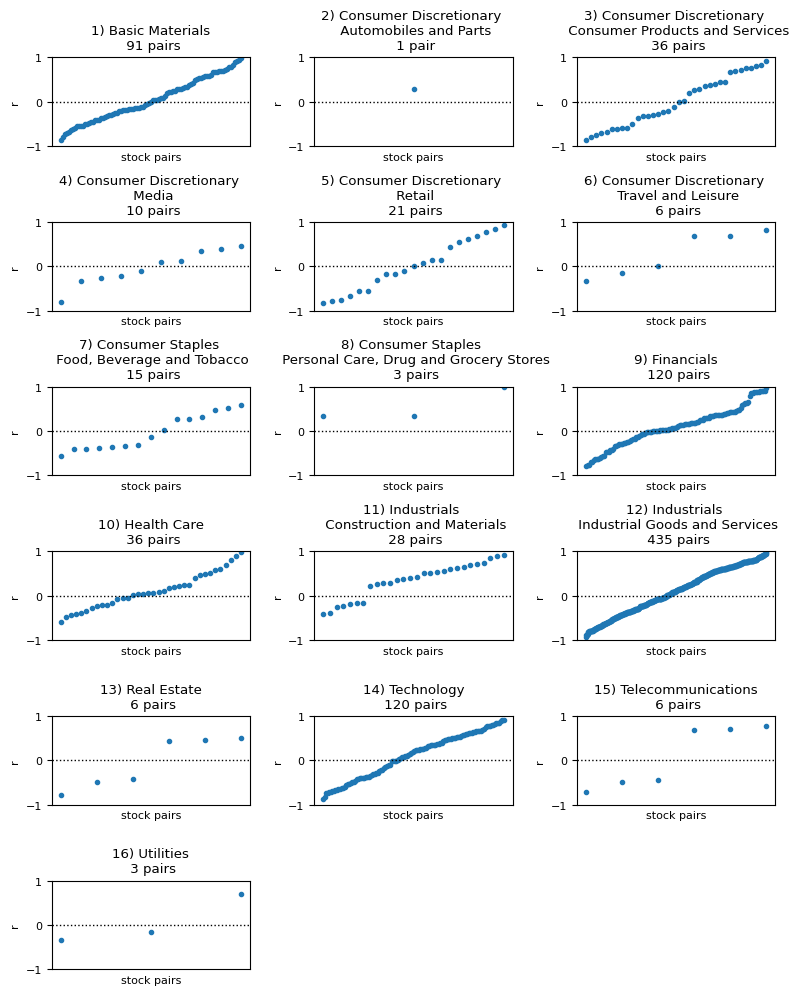

In [1577]:
# Visualise group correlation scores:

n_rows = 6
n_cols = 3
plt.rcParams.update({'font.size':8})
fig = plt.figure(figsize=(8,10))
axes = []
L = len(group_labels)
for i in range(L): 
    i_ord = i+1
    axes.append( fig.add_subplot(n_rows,n_cols,i_ord) )
    this_r = [ r for *_, r in d_gr_corr[ group_labels[i] ] ]
    l = len(this_r)
    plt.plot( this_r, 'o' , markersize = 3)
    this_title = group_labels[i].replace('-','\n')
    if l == 1:
        plu_str = ''
    else:
        plu_str = 's'
    axes[i].set_title(f"{i_ord}) {this_title}\n {l} pair{plu_str}")
    axes[i].set_xlabel('stock pairs')
    axes[i].set_ylabel('r')
    axes[i].invert_xaxis()
    axes[i].set_ylim([-1,1])
    plt.tick_params( axis='x', which='both', bottom=False, labelbottom=False )
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)

plt.tight_layout()
plt.show()

Most plots show no consistent inclination to correlation, be it positive or negative. This is especially clear in groups with a large number of stocks, which tend to an even distribution and in some cases almost resemble a normal distribution.\
$\;\;\;\;\;\;$However, some groups display a gap around zero, indicating positive or negative correlation. This is the case of gorups 11, 13, and 15.
<br></br>

In [1570]:
def vis_group_corr_stocks(data_df,d_gr_corr,i_group,start_date,end_date,r_min_query,r_max_query,rescale_opt):
    """
    Visualise a group of stocks' prices and their pairwise-correlation.
    Compute correlation for time-ranges of less than full data.
    INPUT:
        data_df: [dataframe] row index: Date; colum index: stocks' identifier; data: stock prices
        d_gr_corr: [dictionary] { 'group label' : ['ticker','ticker','r'] } where value is a nested list
        i_group: [int] index of the group 
        start_date: [datetime] inclusive starting date to display (YYYY-MM-DD), '' = from first record 
        end_date: [datetime] inclusive ending date to display (YYYY-MM-DD), '' = until last record
        r_min_query: [float] inclusive minimum correlation to display
        r_max_query: [float] inclusive maximum correlation to display 
        rescale_opt: [boolean] True = rescale to [0,1], False = don't
    """
    group_labels = list(d_gr_ticker.keys())
    this_sel = [ r for r in d_gr_corr[ group_labels[i_group] ] if (r[2] >= r_min_query) & (r[2] <= r_max_query)]
    for row in this_sel:
        print( ' - '.join(row[:2]) , f', r = {round(row[2],4)}' )
    sel_stocks = []
    r_min_global = 1
    r_max_global = -1
    for r in this_sel:
        sel_stocks.extend(r[:2])
        r_min_global = min([r_min_global,r[2]])
        r_max_global = max([r_max_global,r[2]])
    sel_stocks = list(set(sel_stocks))
    l = len(sel_stocks)
    sz = int( (l**2 - l)/2 )
    r_min_global = round(r_min_global,4)
    r_max_global = round(r_max_global,4)
    
    r_global_lbl = f'r = {r_min_global}'
    if r_min_global != r_max_global:
        r_global_lbl = r_global_lbl + f' ... {r_max_global}'
          
    if start_date or end_date:
        r_global_lbl = ' (' + r_global_lbl + f' for {data_df.index[-1].strftime("%Y-%m-%d")} to {data_df.index[0].strftime("%Y-%m-%d")})'
        local_view = True
    else:
        r_global_lbl = ', ' + r_global_lbl
        local_view = False

    if not start_date:
        start_date = data_df.index[-1].strftime('%Y-%m-%d')
    if not end_date:
        end_date = data_df.index[0].strftime('%Y-%m-%d')

    sel_df = data_df.query('index >= @start_date and index <= @end_date')[sel_stocks]
    r_local_lbl = ''
    if local_view:
        corr_df = corrsort(sel_df)
        r_min_local = round( corr_df['r'].iloc[-1] ,4)
        r_max_local = round( corr_df['r'].iloc[0] ,4)
        r_local_lbl = f', r = {r_min_local}'
        if r_min_local != r_max_local:
            r_local_lbl = r_local_lbl + f' ... {r_max_local}'
        r_local_lbl = r_local_lbl + '\n'
    norm_lbl = ''
    curr_lbl = ' (EUR)'
    if rescale_opt:
        sel_df = sel_df.copy()
        sel_df = sel_df - sel_df.min()
        sel_df = sel_df / sel_df.max()
        norm_lbl = ', rescaled '
        curr_lbl = ' (rescaled)'
    plt.rcParams.update({'font.size':8})
    fig, ax = plt.subplots()
    sel_df.plot( ax = ax )
    g_lbl = group_labels[i_group].replace('-','\n')
    if sz == 1:
        plu_str = ''
    else:
        plu_str = 's'
    corr_lbls = f'{start_date} - {end_date}{norm_lbl}{r_local_lbl}{r_global_lbl}'
    ax.set_title(f"{i_group+1}) {g_lbl}\n {sz} pair{plu_str}\n{corr_lbls}")
    ax.legend(bbox_to_anchor=(1, 1.03), loc='upper left')
    plt.ylabel(f'price{curr_lbl}')


LEHTO - SITOWS , r = 0.925
GLA1V - LEHTO , r = 0.8843
PURMO - SRV1V , r = 0.8534
LEHTO - YIT , r = 0.7446
SITOWS - TULAV , r = 0.7251
LEHTO - TULAV , r = 0.7004
LEHTO - PURMO , r = 0.6498
KREATE - SRV1V , r = 0.6344
KREATE - PURMO , r = 0.601
PURMO - YIT , r = 0.5473
GLA1V - KREATE , r = 0.5445
SITOWS - YIT , r = 0.5218
GLA1V - PURMO , r = 0.5046
SRV1V - YIT , r = 0.4271
GLA1V - SRV1V , r = 0.3941
KREATE - LEHTO , r = 0.3794
GLA1V - YIT , r = 0.3615
TULAV - YIT , r = 0.2899
GLA1V - SITOWS , r = 0.2801
KREATE - YIT , r = 0.2683
GLA1V - TULAV , r = 0.2227
KREATE - TULAV , r = -0.169
LEHTO - SRV1V , r = -0.1691
PURMO - SITOWS , r = -0.1917
PURMO - TULAV , r = -0.2242
KREATE - SITOWS , r = -0.252
SITOWS - SRV1V , r = -0.381
SRV1V - TULAV , r = -0.4181


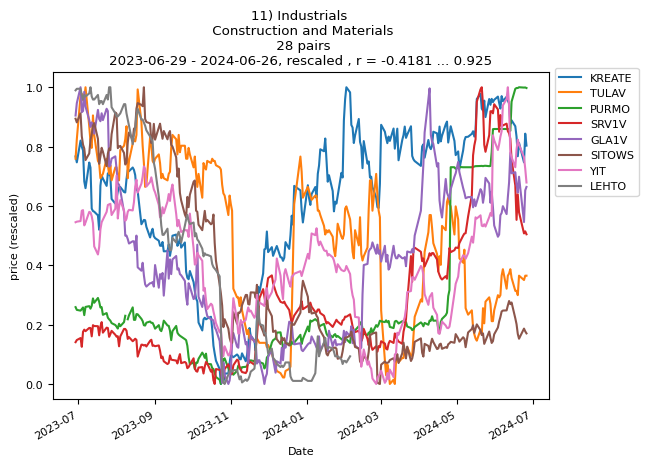

In [1571]:
# Visualise stock group:

i_group = 10

r_min_query = -1 # <--- correlation minimum
r_max_query = 1 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_group_corr_stocks(data_df,d_gr_corr,i_group,start_date,end_date,r_min_query,r_max_query,rescale_opt)

The group 'Industrials - Construction and Materials' displays overall prices consistent with the global markets reaching minima at the end of October of 2023. No other pattern is evident from this plot.
<br></br>

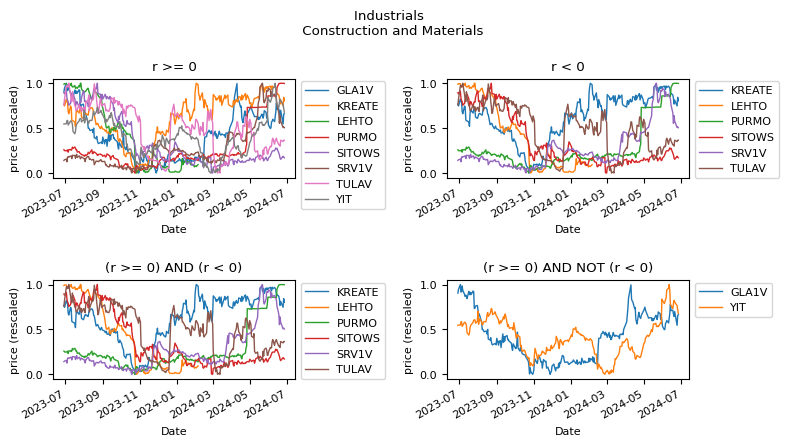

In [1574]:
# Identify stocks that correlate positively and negatively:

i_group = 10 
rescale_opt = 1

gr_lbl = list(d_gr_ticker.keys())[i_group]
this_group = d_gr_corr[ gr_lbl ]
i_split = 0
for *_, r in this_group:
    if r < 0:
        break
    i_split += 1

def flatten(arr):
    nested_list = [e[:2] for e in arr]
    flat_list = []
    for e in nested_list:
        flat_list.extend(e)
    return set(flat_list)
    
sel_t = []
sel_t.append( [ 'r >= 0', flatten( this_group[:i_split])] )
sel_t.append( [ 'r < 0', flatten( this_group[i_split:])] )
sel_t.append( [ '(r >= 0) AND (r < 0)', pos_t.intersection( sel_t[1][1])] )
sel_t.append( [ '(r >= 0) AND NOT (r < 0)', sel_t[0][1].difference(sel_t[2][1])] )
sel_t.append( [ '(r < 0) AND NOT (r >= 0)',sel_t[1][1].difference(sel_t[2][1])] )

L = len(sel_t)
n_rows, n_cols = n_rowcol(L,1)

axes = []
plt.rcParams.update({'font.size':8})
fig = plt.figure(figsize=(8,8))
for i in range(L):
    
    t = sorted(sel_t[i][1])
    if t:
        #print(f'{sel_t[i][0]} : ', ', '.join( t ) )

        i_ord = i+1
        axes.append( fig.add_subplot(n_rows,n_cols,i_ord) )
        sel_df = data_df[ list(t) ]
        if rescale_opt:
            sel_df = sel_df.copy()
            sel_df = sel_df - sel_df.min()
            sel_df = sel_df / sel_df.max()
            curr_lbl = ' (rescaled)'
        sel_df.plot( ax = axes[i] , linewidth=1)
        nl = '\n'
        axes[i].set_title(f"{nl}{sel_t[i][0]}")
        axes[i].legend(bbox_to_anchor=(1, 1.03), loc='upper left')
        plt.ylabel(f'price{curr_lbl}')

plt.suptitle(gr_lbl.replace('-','\n'))
plt.tight_layout()
plt.show()

These plots for subgroups of 'Industrials - Construction and Materials' according to more detailed grouping of correlation show that despite high pairwise correlation (positive or negative), there is no evident trend as a group beyond October 2023. Only the pair GLA1V (Glaston )and YIT (YIT Corporation) do not correlate negatively with other stocks in the group, althoguh their correlation is rather low (r = 0.36).
<br></br>

INVEST - KOJAMO , r = 0.5118
INVEST - OVARO , r = 0.4492
KOJAMO - OVARO , r = 0.4408
CTY1S - KOJAMO , r = -0.4203
CTY1S - INVEST , r = -0.4943
CTY1S - OVARO , r = -0.7838


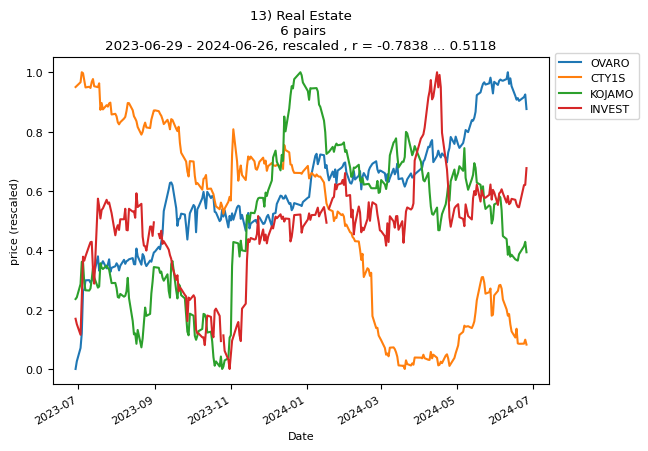

In [1575]:
# Visualise stock group:

i_group = 12

r_min_query = -1 # <--- correlation minimum
r_max_query = 1 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_group_corr_stocks(data_df,d_gr_corr,i_group,start_date,end_date,r_min_query,r_max_query,rescale_opt)

The group 'Real Estate' displays an upwards trend except for CTY1S (Citycon).
<br></br>

ELISA - TLT1V , r = 0.7806
ELISA - NOKIA , r = 0.697
NOKIA - TLT1V , r = 0.6926
NOKIA - TELIA1 , r = -0.4434
ELISA - TELIA1 , r = -0.497
TELIA1 - TLT1V , r = -0.7183


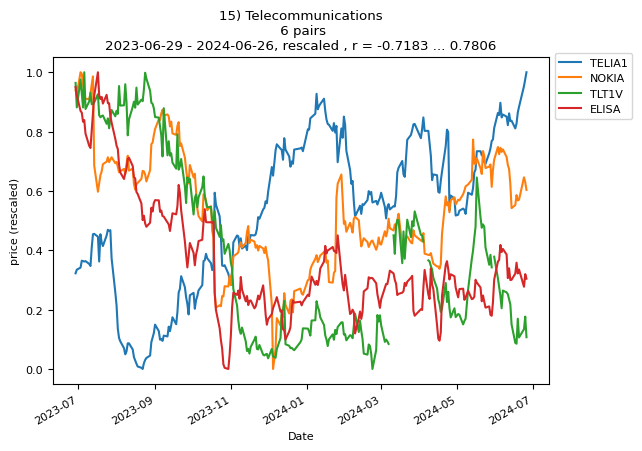

In [1576]:
# Visualise stock group:

i_group = 14

r_min_query = -1 # <--- correlation minimum
r_max_query = 1 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_group_corr_stocks(data_df,d_gr_corr,i_group,start_date,end_date,r_min_query,r_max_query,rescale_opt)

The group 'Telecommunications' displays a mostly coherent movement towards minima at the end of october 2023, as with the global markets. However, TELIA1 (Telia Company) displays a different behaviour.
<br></br>

In [34]:
connection.close()